# Inspecting Trained Convolutional Neural Networks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_03_CNN_inspect_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_03_CNN_inspect_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
# Cell to normalize local and Colab environments.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-rc0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [2]:
# Additional imports and configs
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


In [4]:
# Import data for a specific subject.
from data.utils.fileio import load_faces_houses

SUB_ID = 'mv'
MAX_OFFSET = 100

X, Y, ax_info = load_faces_houses(datadir, SUB_ID, feature_set='full')
classes, _y = np.unique(Y, return_inverse=True)
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 603 trials, 801 timestamps (-0.2 to 0.6 at 1000 Hz), 58 channels


In [5]:
# Load the 'best' model from disk.
from tensorflow.keras.models import load_model
model = load_model(datadir / 'models' / (SUB_ID + '_model_best_all.h5'))
model.summary()

W0903 18:19:08.322943 140224503703360 deprecation.py:323] From /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, 58, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, 58, 7)   266         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, 58, 4)   480         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, 58, 11)  0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

## Low-dimensional projection

### t-Distributed Stochastic Neighbour Embedding

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw inputs do not decompose very well so for inputs we will use first use PCA.

5


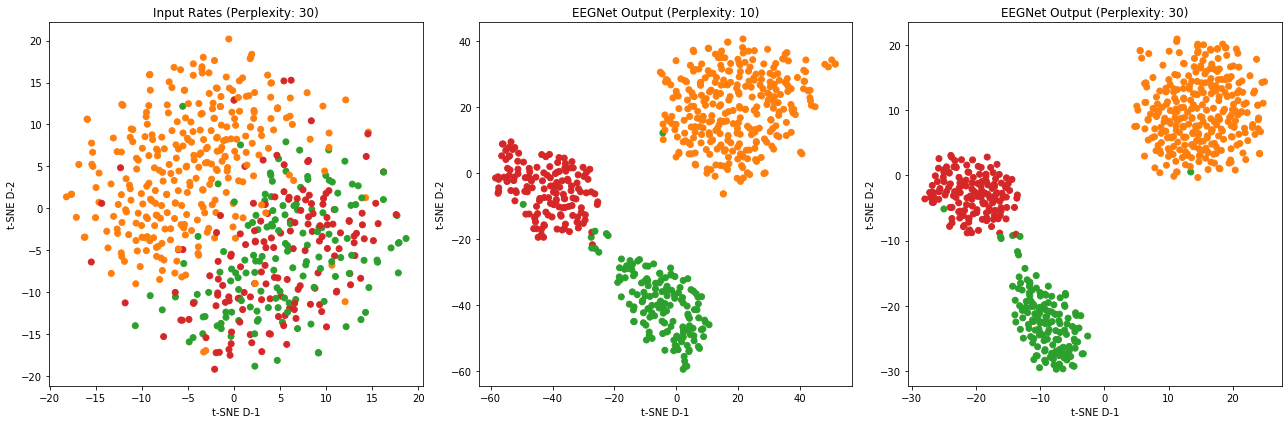

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

TEST_PERPLEXITY = [10, 30]

fig = plt.figure(figsize=(18, 6), facecolor='white')
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Perplexity: {})'.format(perplexity))
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, _y.ravel()+1, TEST_PERPLEXITY[-1], title='Input Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -3
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
flattened_output = tf.concat(flattened_output, 0)
reset_keras(truncated_model)

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(flattened_output)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel()+1, perplexity, title='EEGNet Output')

plt.tight_layout()
# fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

## Temporal Filters - Convolution kernel

The first pair of parallel convolutional layers are simply performing time-domain convolutions on the raw data. Whereas a typical signal processing pipeline will apply a convolution kernel for FIR bandpass filtering to isolate physiological bands (e.g., beta, gamma), here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

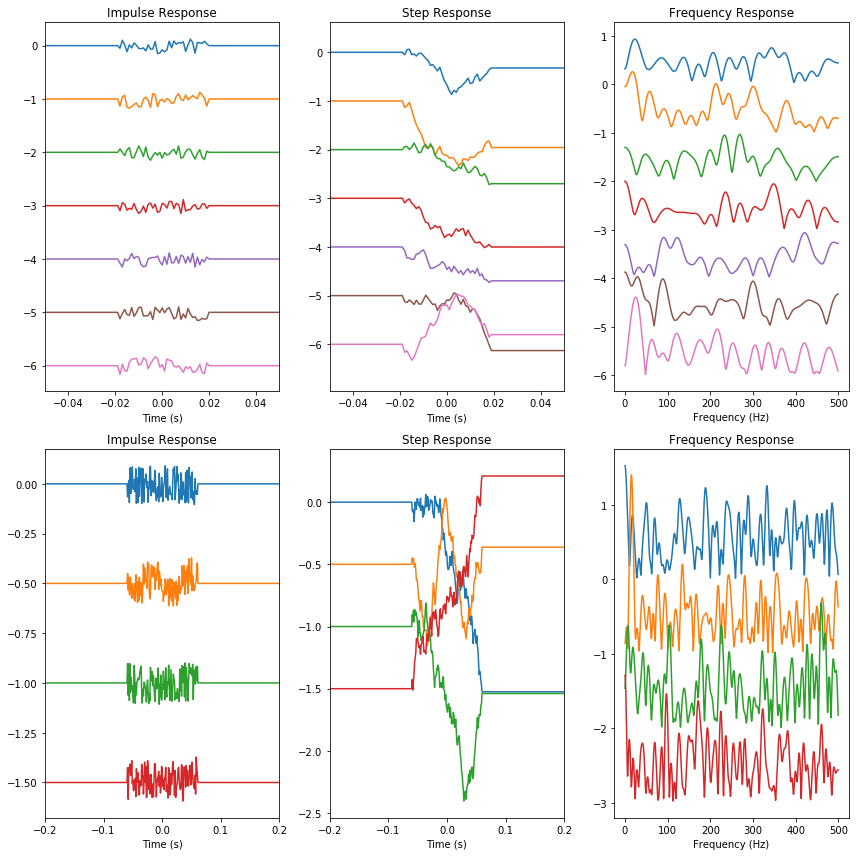

In [7]:
import scipy.signal

fig = plt.figure(figsize=(12, 12), facecolor='white')
t = ax_info['timestamps']

x_ranges = [[-0.05, 0.05], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

## Spatial Filters

The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 58-channel inputs to D*n_temporal_filter features.

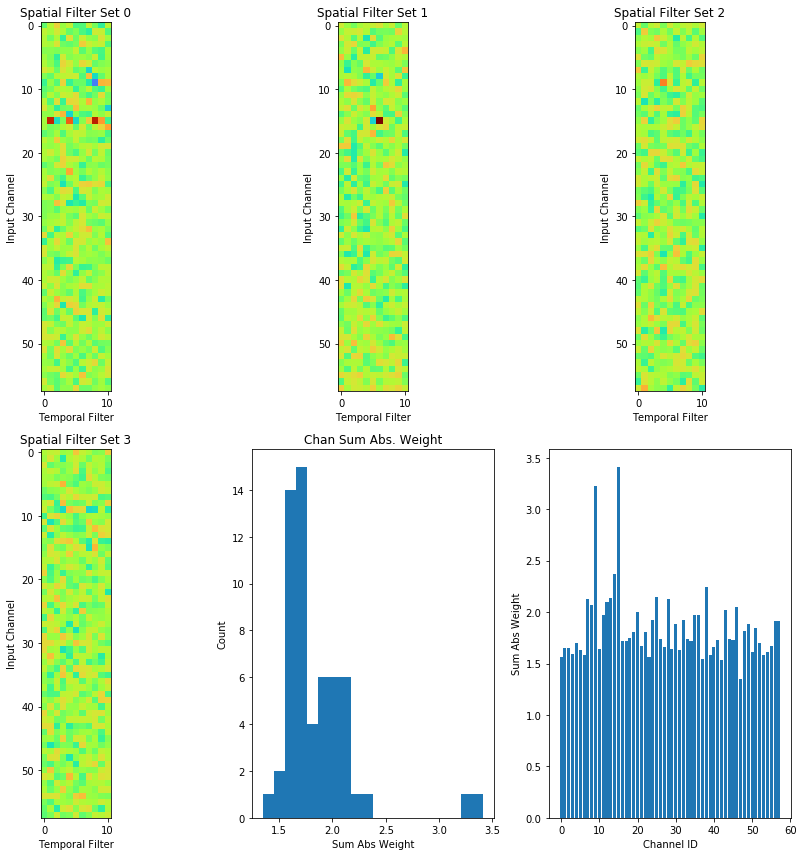

Top channels: ['Fusiform Gyrus.2' 'Fusiform Gyrus.0' 'Lingual Gyrus.3'
 'Non-Included Area.20']
Bottom channels: ['Parahippocampal Gyrus.0' 'Non-Included Area.19' 'Non-Included Area.24'
 'Non-Included Area.29']


In [8]:
LAYER_IX = 5
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending
print("Top channels: {}".format(ax_info['channel_names'][ch_ids][:4]))
print("Bottom channels: {}".format(ax_info['channel_names'][ch_ids][-4:]))

There seems to be 1 or 2 channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Generate Inputs to Maximize Filter Activations

For many internal layers of a model for which there is no clear interpretation, there is another method we can use to try to understand what the layer is doing: we find an input that maximizes the activation of that filter.

You can find some nice pre-existing code for doing exactly this in image data with old versions of tensorflow: [keras-filter-visualization](https://github.com/jacobgil/keras-filter-visualization), and [DeepExplain](https://github.com/marcoancona/DeepExplain). Unfortunately, both of these repos, and indeed all online examples that I've found, are not suitable for our purposes. One difference is that in image processing, the two spatial dimensions are physically constrained and there are no remapping from (e.g.) old_columns to new_columns, but in our data we do remap from ECoG_channels to some_features.

So let's do it ourselves! We first create a smaller version of our model that runs from the input to the inspected layer.

In [9]:
layer_ix = 10  # 10: separable_conv2d
truncated_model = tf.keras.Model(model.input, model.layers[layer_ix].output)

Whereas in most DL contexts the output is something that we can compare to known values and calculate a loss indicative of model performance, here the output is simply the activation of a model layer. We fabricate a 'loss', which is simply the output of a filter within the layer.

Typically during model fitting, we calculate the gradients of the model weights w.r.t. the loss (which is normally bad) and descend the weights down the gradient to reduce the loss. Instead, here we calculate the gradients of the _input_ w.r.t. 'loss' (which is good) and ascend the input to further increase the 'loss'. We start off with random input data and modify it iteratively until it maximizes filter activation.

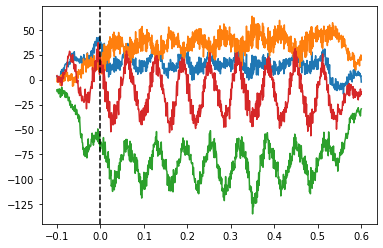

In [10]:
from tensorflow.keras import backend as K

filter_ix = 0  # <-- Change me! Any integer in range(36)
n_steps = 100
t_vec = ax_info['timestamps']

# Fabricate random input
in_shape = [1] + truncated_model.input.shape.as_list()[1:]
input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))

for step_ix in range(n_steps):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        # Run the input through our truncated model
        layer_act = truncated_model(input_data)
        # Get the activation for a particular filter in the output layer
        filt_act = layer_act[:, :, :, filter_ix]
        # The 'loss' is simply the average activation of the filter.
        loss_value = K.mean(filt_act)
    grads = tape.gradient(loss_value, input_data)
    grads /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    input_data += grads

input_data = np.squeeze(input_data)
plt.plot(t_vec[MAX_OFFSET:], input_data[:, ch_ids[:4]])
plt.axvline(0, color='k', linestyle='--')
plt.show()

We have a helper function that can do the above process simultaneously for multiple filters within a layer:

In [11]:
from indl.cnn_helper_1D import get_maximizing_inputs

N_FILTS_DISP = 9
input_tups = get_maximizing_inputs(model, layer_ix, max_filts=N_FILTS_DISP)

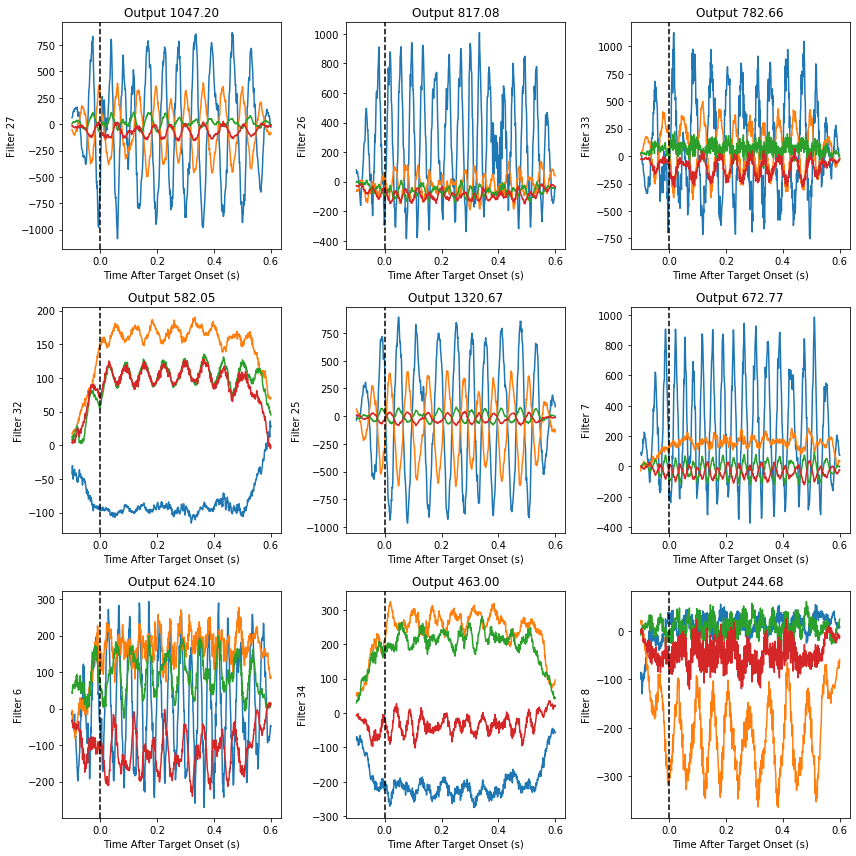

In [12]:
fig = plt.figure(figsize=(12, 12), facecolor='white')
sp_cols = int(np.ceil(np.sqrt(len(input_tups))))
sp_rows = int(np.ceil(len(input_tups) / sp_cols))

for plt_ix, in_tup in enumerate(input_tups):
    plt.subplot(sp_rows, sp_cols, plt_ix + 1)
    plt.plot(t[MAX_OFFSET:], in_tup[1][:, ch_ids[:4]])
    plt.xlabel('Time After Target Onset (s)')
    plt.ylabel('Filter {}'.format(in_tup[0]))
    plt.title('Output {:.2f}'.format(in_tup[2]))
    plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()

We can also add a slight twist: the loss is calculated as the difference between the activation of the selected filter and the average activation of all other filters. This is intended to find an input that maximally activates one filter while minizing the other filters.

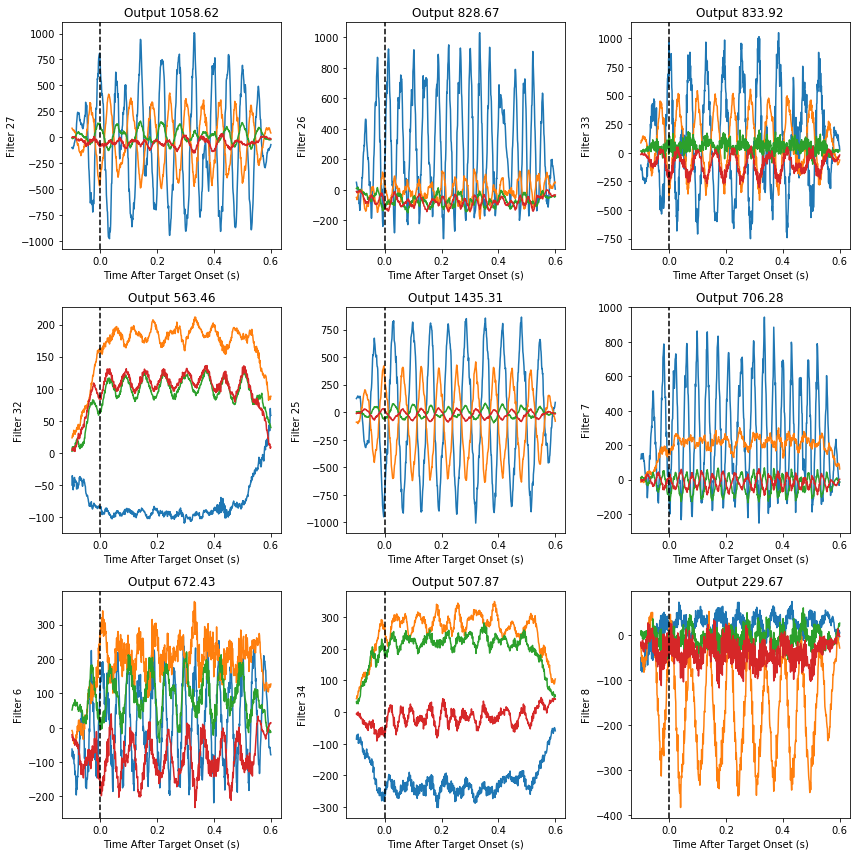

In [13]:
_max_filts = [_[0] for _ in input_tups]
x_input_tups = get_maximizing_inputs(model, layer_ix, max_filts=_max_filts,
                                     at_others_expense=True)

fig = plt.figure(figsize=(12, 12), facecolor='white')
sp_cols = int(np.ceil(np.sqrt(len(x_input_tups))))
sp_rows = int(np.ceil(len(x_input_tups) / sp_cols))

for plt_ix, in_tup in enumerate(x_input_tups):
    plt.subplot(sp_rows, sp_cols, plt_ix + 1)
    plt.plot(t[MAX_OFFSET:], in_tup[1][:, ch_ids[:4]])
    plt.xlabel('Time After Target Onset (s)')
    plt.ylabel('Filter {}'.format(in_tup[0]))
    plt.title('Output {:.2f}'.format(in_tup[2]))
    plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()

It makes more sense to do that when we're looking at penultimate layer, i.e. the layer with a single filter per class, but has yet to go through the SoftMax activation.

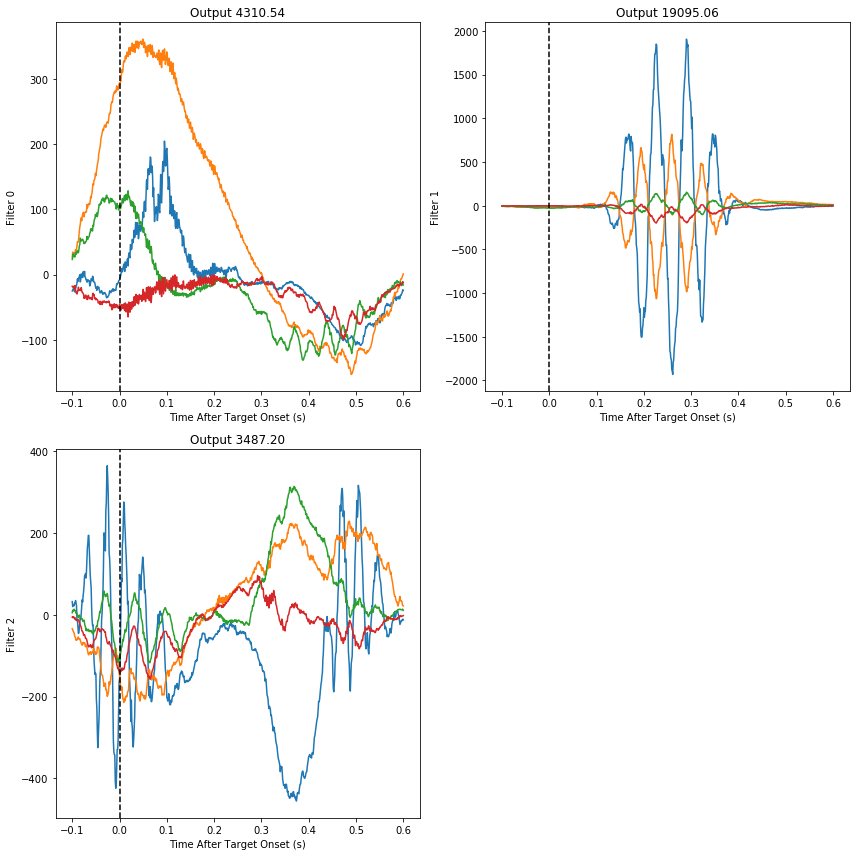

In [15]:
layer_ix = len(model.layers) - 2

x_input_tups = get_maximizing_inputs(model, layer_ix,
                                     at_others_expense=True)

fig = plt.figure(figsize=(12, 12), facecolor='white')
sp_cols = int(np.ceil(np.sqrt(len(x_input_tups))))
sp_rows = int(np.ceil(len(x_input_tups) / sp_cols))

for plt_ix, in_tup in enumerate(x_input_tups):
    plt.subplot(sp_rows, sp_cols, plt_ix + 1)
    plt.plot(t[MAX_OFFSET:], in_tup[1][:, ch_ids[:4]])
    plt.xlabel('Time After Target Onset (s)')
    plt.ylabel('Filter {}'.format(in_tup[0]))
    plt.title('Output {:.2f}'.format(in_tup[2]))
    plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()

## Real Input - Saliency & Class-Activation Maps